In [5]:
%precision %.5g
from tqdm import tqdm_notebook

INFERENCE_ONLY = True

import os
root = os.environ['HOME'] + '/'
competition_name = "tgs-salt-identification-challenge"
short_comp_name = "salt"
DATASET_PATH     = root + "datasets/competitions/" + competition_name
SAVE_PATH        = root + "models/" + short_comp_name + '/'
SUBMISSIONS_PATH = root + "submissions/" + short_comp_name + '/'
SRC_PATH         = root + "code/berloga-dl/"

COMP_SRC_PATH    = SRC_PATH + short_comp_name
LENIN_SRC_PATH   = SRC_PATH + "lenin"


SUBMISSION_NAME = 'st1_2018-10-08-032757_cce4841_seed-4621_albunet34_--_92_0.2342_0.8650.csv'

SUBMISSION = SUBMISSION_PATH + SUBMISSION_NAME

TEST_PATH = DATASET_PATH + '/test/images/'

In [7]:
import sys
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline
sys.path.insert(0, COMP_SRC_PATH)
from src.utils import *

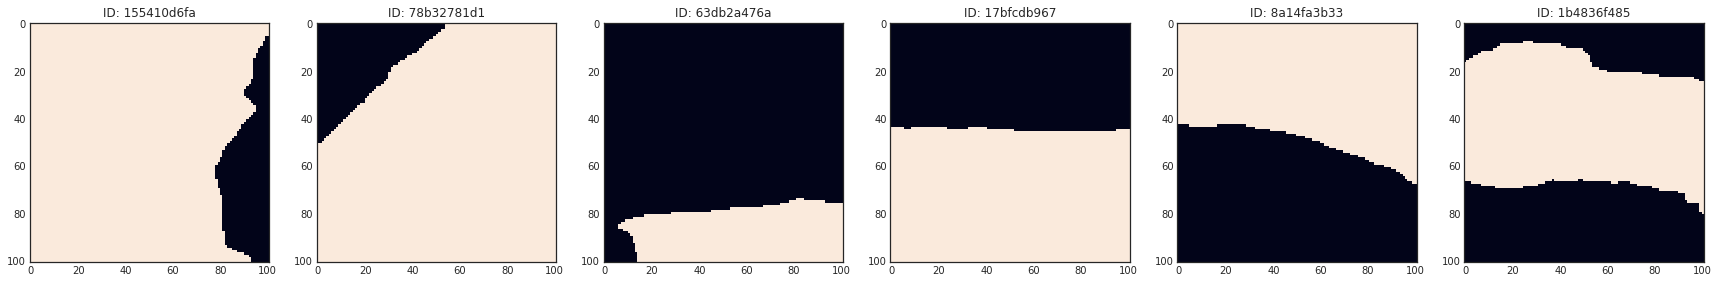

In [8]:
"""
reading and decoding the submission 

"""
df = pd.read_csv(SUBMISSION)
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

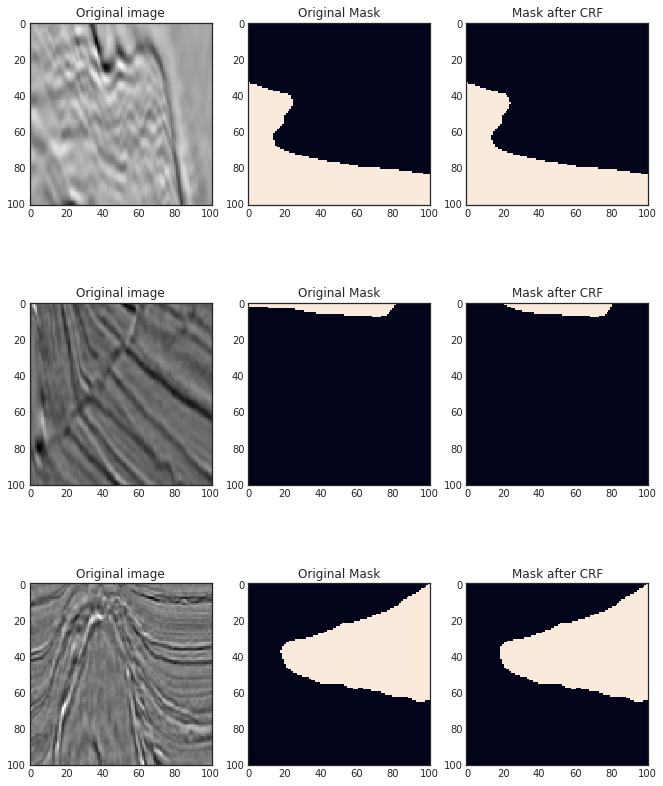

In [9]:
"""
visualizing the effect of applying CRF

"""
nImgs = 3
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(TEST_PATH+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [10]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(TEST_PATH+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

100%|██████████| 18000/18000 [02:03<00:00, 146.01it/s]


In [11]:
submission_path = SUBMISSION.replace('.csv', '-with-crf.csv')
df.to_csv(submission_path,index=False)
print(submission_path)

/home/saint/submissions/salt/st1_2018-10-08-032757_cce4841_seed-4621_albunet34_--_92_0.2342_0.8650-with-crf.csv


In [12]:
m = submission_path.replace(':', '\:').replace('(', '\(').replace(')', '\)')
!kaggle c submit -f {m} -m '{submission_path}' -c tgs-salt-identification-challenge

Successfully submitted to TGS Salt Identification Challenge